In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from collections import defaultdict
import networkx as nx
from qiskit.circuit import ParameterVector, Parameter
from docplex.mp.model import Model
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

from qiskit_braket_provider import BraketProvider


In [2]:
service = QiskitRuntimeService()
service_braket = BraketProvider()


# Load problems

In [12]:
data = np.load("/Users/alejomonbar/Documents/GitHub/LR-QAOA-QPU-Benchmarking/Data/ibm_fez/156_HE_fractional.npy", allow_pickle=True).item()

In [39]:
json_data = {}
json_data["graph"] = {str(edge):float(data["G"][edge[0]][edge[1]]["weight"]) for edge in data["G"].edges}
json_data["optimal_solution"] = data["sols"][0]
json_data["parameters"] = {}
json_data["r_ibm_fez"] = {}
delta = data["Deltas"][0]
for p in data["ps"]:
    betas = [float(i) for i in np.arange(1, p + 1)[::-1] * delta / p]
    gammas = [float(j) for j in np.arange(1, p + 1) * delta / p]
    json_data["parameters"][p] = {"betas": betas, "gammas": gammas}
    json_data["r_ibm_fez"][p] = float(data["postprocessing"][delta][p]["r"])

import json
with open("/Users/alejomonbar/Documents/GitHub/LR-QAOA-QPU-Benchmarking/Data/ibm_fez/156_HE_fractional.json", "w") as f:
    json.dump(json_data, f, indent=4)

In [7]:
problems = np.load("./Data/WMC_FC.npy", allow_pickle=True).item()


In [8]:
backends = {}

# backends["ibm_marrakesh"] = service.backend('ibm_marrakesh')
# backends["ibm_fez"] = service.backend('ibm_fez')
# backends["ibm_torino"] = service.backend('ibm_torino')
# backends["ibm_brisbane"] = service.backend('ibm_brisbane')

# backends["mps"] = service.backend("simulator_mps")
# backends["qasm_simulator"] = AerSimulator()

# Main 1D-Chain IBM QPUs

In [9]:
qubits_in_line = {}
# Eagle device
qubits_1D_Eagle = list(range(13,-1,-1)) + [14] + list(range(18,33)) + [36] + list(range(51,36,-1)) + [52] + list(range(56,71)) + [74] + list(range(89,74,-1)) + [90] + list(range(94,109)) + [112] + list(range(126,112,-1))

for backend in backends.keys():
    if backend[:3] == "ibm" and backend != "ibm_torino":
        qubits_in_line[backend] = qubits_1D_Eagle

# Heron device
qubits_in_line["ibm_torino"] = list(range(14,-1,-1)) + [15] + list(range(19,34)) + [37] + list(range(52,37,-1)) + [53] + list(range(57,72)) + [75] + list(range(90,75,-1)) + [91] + list(range(95,110)) + [113] + list(range(128,113,-1)) + [129]
qubits_in_line["ibm_fez"] = list(range(0,16)) + [19] + list(range(35,20,-1)) + [36] + list(range(41,56)) + [59] + list(range(75,60,-1)) + [76] + list(range(81,96)) + [99] + list(range(115,100,-1)) + [116] + list(range(121,136)) + [139] + list(range(155,139,-1))
qubits_in_line["ibm_marrakesh"] = list(range(0,16)) + [19] + list(range(35,20,-1)) + [36] + list(range(41,56)) + [59] + list(range(75,60,-1)) + [76] + list(range(81,96)) + [99] + list(range(115,100,-1)) + [116] + list(range(121,136)) + [139] + list(range(155,139,-1))
qubits_in_line["iqm_garnet"] =[2, 3, 0, 1, 4, 5, 6, 11, 10, 9, 8, 7, 12, 13, 14, 15, 19, 18, 17]

# QAOA Circuit - SWAP network strategy for 1D-Chain connectivity

In [ ]:
from qiskit import QuantumCircuit
import numpy as np

def layer_1D_full_Graph(G, gamma):
    """
    Constructs a single layer of the QAOA circuit for a 1D swap network.

    Parameters:
    - G (networkx.Graph): The problem graph, where nodes represent qubits, 
                          and edges contain weights for interactions.
    - gamma (float): The parameter controlling the evolution of the cost Hamiltonian.

    Returns:
    - layer (QuantumCircuit): A quantum circuit implementing the ZZ evolution with swaps.
    """
    num_qubits = G.number_of_nodes()
    
    # Track current qubit permutation due to swaps
    permutation = np.arange(num_qubits)
    
    # Normalize edge weights
    max_weight = np.max(np.abs([G[i][j]["weight"] for i, j in G.edges()]))

    # Initialize the quantum circuit for one layer
    layer = QuantumCircuit(num_qubits)
    
    # Implement the swap network with RZZ gates
    for i in range(num_qubits):
        for j in range(i % 2, num_qubits - 1, 2):
            # Apply a controlled-X (CNOT) gate
            layer.cx(j, j + 1)
            
            # Apply a weighted RZ rotation on the second qubit
            layer.rz(2 * G[permutation[j]][permutation[j + 1]]["weight"] * gamma / max_weight, j + 1)
            
            # Undo the CX gate sequence to restore original states
            layer.cx(j + 1, j)
            layer.cx(j, j + 1)
            
            # Update the permutation due to the swap
            permutation[[j, j + 1]] = permutation[[j + 1, j]]

    return layer


def qaoa_swap_network(G, gammas, betas):
    """
    Constructs a full QAOA circuit using a swap network for a 1D architecture.

    This is useful for fully connected problems (e.g., complete graphs) where
    all qubits need pairwise interactions.

    Parameters:
    - G (networkx.Graph): The problem graph with weighted edges.
    - gammas (list of floats): The QAOA parameters for cost Hamiltonian evolution.
    - betas (list of floats): The QAOA parameters for mixer Hamiltonian evolution.

    Returns:
    - circ (QuantumCircuit): The full QAOA quantum circuit.
    """
    num_qubits = G.number_of_nodes()
    p = len(gammas)  # Number of QAOA layers

    # Initialize the QAOA quantum circuit
    circ = QuantumCircuit(num_qubits)

    # Apply the initial layer of Hadamard gates to all qubits
    for i in range(num_qubits):
        circ.h(i)
    # Function to generate each layer
    layer = lambda gamma: layer_1D_full_Graph(G, gamma)

    # Add p layers of QAOA
    for pi in range(p):
        # Apply the cost Hamiltonian evolution (ZZ interactions with swaps)
        circ = circ.compose(layer(gammas[pi]), 
                            range(num_qubits) if not pi % 2 else reversed(range(num_qubits)))
        # Apply the mixer Hamiltonian evolution (RX rotations)
        circ.rx(-2 * betas[pi], range(num_qubits))    
    return circ


In [34]:
def cost_maxcut(bitstring, weights):
    """
    Computes the cost of a given bitstring solution for the Max-Cut problem.

    Parameters:
    bitstring (str): A binary string representing a partition of the graph nodes (e.g., "1010").
    weights (dict): A dictionary where keys are edge tuples (i, j) and values are edge weights.

    Returns:
    float: The computed cost of the Max-Cut solution.
    """
    cost = 0  # Initialize the cost
    
    # Iterate through all edges in the graph
    for i, j in weights.keys():
        # Check if the nodes i and j are in different partitions (cut condition)
        if bitstring[i] + bitstring[j] in ["10", "01"]:
            cost += weights[i, j]  # Add the edge weight to the cost

    return cost  # Return the total cut cost


def objective_MaxCut(samples_dict, G, optimal):
    """
    Evaluates the performance of a quantum algorithm for the Max-Cut problem.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    optimal (str): The optimal bitstring solution found by classical solvers (e.g., CPLEX).

    Returns:
    dict: A dictionary containing:
        - "results": A numpy array with computed cost, normalized cost ratio, and counts.
        - "G": The input graph G.
        - "weights": The edge weights extracted from G.
        - "max_cut": The cost of the optimal Max-Cut solution.
        - "r": The expected approximation ratio.
        - "probability": The probability of sampling the optimal solution.
    """

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    
    # Compute the cost of the optimal Max-Cut solution
    max_cost = cost_maxcut(optimal, weights)

    results = []  # Stores results in the form [cost, ratio, counts]
    probability = 0  # Tracks probability of sampling the optimal solution

    # Iterate through all sampled bitstrings
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, weights)  # Compute cost of the given bitstring
        r = cost / max_cost  # Compute the cost ratio relative to the optimal solution
        results.append([cost, r, counts])  # Store results
        
        # If this bitstring matches the optimal cost, update probability
        if abs(cost - max_cost) < 1e-6:
            probability += counts
        
        # Check if a better-than-optimal solution appears (sanity check)
        if cost > max_cost:
            print(f"There is a better cost than that of CPLEX: {cost - max_cost}")

    # Convert results to a NumPy array for easy computation
    results = np.array(results)

    # Total number of shots (total sampled solutions)
    shots = np.sum(results[:, 2])

    # Compute the expected approximation ratio: (weighted sum of costs) / (shots * max_cost)
    rT = np.sum(results[:, 0] * results[:, 2]) / (shots * max_cost)

    # Normalize the probability of sampling the optimal solution
    probability /= shots

    # Return results in a structured dictionary
    return {
        "results": np.array(results),
        "G": G,
        "weights": weights,
        "max_cut": max_cost,
        "r": rT,
        "probability": probability
    }

def mitigate(samples_dict, G, random=False):
    """
    Applies error mitigation by flipping individual bits in sampled solutions 
    to find better Max-Cut solutions.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    random (bool, optional): If True, randomizes the order in which qubits are flipped.
                             Default is False (systematic flipping).

    Returns:
    dict: A dictionary of improved bitstring samples with their updated counts.
    """

    # Define a mapping to flip bits ('0' -> '1', '1' -> '0')
    change = {"0": "1", "1": "0"}

    # Get the number of nodes (qubits)
    nq = G.number_of_nodes()

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}

    # Dictionary to store new (improved) samples
    new_samples = defaultdict(int)

    # Iterate over all bitstring samples
    for bitstring, counts in samples_dict.items():
        for _ in range(counts):  # Process each occurrence of the bitstring separately
            best_string = bitstring  # Initialize the best solution as the current one
            best_cost = cost_maxcut(bitstring, weights)  # Compute its cost
            
            # Create an ordered list of qubits (nodes) to consider flipping
            list_qubits = np.arange(nq)
            
            # If random flipping is enabled, shuffle the qubit order
            if random:
                np.random.shuffle(list_qubits)

            # Try flipping each qubit and check if the cost improves
            for qi in list_qubits:
                # Flip the bit at position qi
                new_string = "".join((change[i] if n == qi else i) for n, i in enumerate(best_string))
                new_cost = cost_maxcut(new_string, weights)

                # If the new configuration gives a better cost, update the best solution
                if new_cost > best_cost:
                    best_string = new_string
                    best_cost = new_cost
            
            # Store the improved bitstring in the new_samples dictionary
            new_samples[best_string] += 1

    return new_samples  # Return the mitigated samples

def random_samples(num_samples, n_qubits):
    """
    Generates random bitstring samples for a given number of qubits.

    Parameters:
    num_samples (int): The number of random bitstrings to generate.
    n_qubits (int): The number of qubits (length of each bitstring).

    Returns:
    dict: A dictionary where keys are randomly generated bitstrings 
          and values are their occurrence counts.
    """
    
    random_samples = defaultdict(int)  # Dictionary to store bitstrings and their counts

    # Generate random bitstrings and count their occurrences
    for _ in range(num_samples):
        bitstring = "".join(str(i) for i in np.random.choice([0, 1], n_qubits))  # Generate a random bitstring
        random_samples[bitstring] += 1  # Increment count for the generated bitstring

    return random_samples  # Return the dictionary of samples


# Prepare experiments

In [ ]:
# Initialize an empty dictionary to store results
results = {}

# Define the backend for quantum computation (uncomment the desired backend)
# backend_name = "ibm_brisbane"
# backend_name = "ibm_sherbrooke"
# backend_name = "ibm_kyiv"
# backend_name = "ibm_nazca"
# backend_name = "ibm_osaka"
# backend_name = "ibm_kyoto"
# backend_name = "ibm_torino"
# backend_name = "ibm_fez"
# backend_name = "ibm_marrakesh"  # Selected backend
backend_name = "iqm_garnet"  # Selected backend
# backend_name = "qasm_simulator"  # Uncomment to use a classical simulator

# Get the backend from the available backends dictionary
backend = backends[backend_name]

# Number of qubits used in the problem
nq = 10

# Define qubit mapping for the QASM simulator
qubits_in_line["qasm_simulator"] = range(nq)

# Define delta values for parameter tuning in QAOA (uncomment as needed)
# deltas = [0.05, 0.1, 0.2, 0.3, 0.5, 0.63] # For 50 qubits
# deltas = np.linspace(0.4, 1, 10)  # Generates evenly spaced deltas
# deltas = [0.3]  # Alternative single delta value
deltas = {5:[0.63], 7:[0.63], 10:[0.63],12:[0.63],15:[0.63],17:[0.63],18:[0.3],19:[0.3]}[nq]  # Chosen delta for this experiment

# Store delta values in results
results["Deltas"] = deltas

# Load the problem graph for the given number of qubits
G = problems[nq]["G"]
results["G"] = G  # Store the graph in results

# Get the device-specific qubit layout
qubits_device = qubits_in_line[backend_name] 
# qubits_device = range(nq)


# Calculate the number of sections (repetitions) based on available qubits
reps = len(qubits_device) // nq if backend_name != "qasm_simulator" else 1
results["sections"] = reps  # Store the number of sections

# Determine the maximum number of qubits available in the backend
max_qubits = backend.num_qubits if backend_name != "qasm_simulator" else nq

# Define the number of QAOA layers (ps values) to test
# ps = [0, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 40, 50]  # Alternative set
ps = [3, 4, 5, 6, 7, 8, 9, 10]  # Selected set of layers
# ps = [3, 5, 10, 20]  # Alternative smaller set
# ps = [20]  # Single depth experiment

# Store layer values and optimal solution in results
results["ps"] = ps
results["optimal"] = problems[nq]["sol"]

# Dictionary to store transpiled circuits
circuits_transpiled = {}

# Loop through different values of p (QAOA layers)
for p in ps:
    print(f"---------  p: {p}  ----------")  # Print progress

    # Define QAOA parameters as symbolic variables
    betas = ParameterVector("betas", p)
    gammas = ParameterVector("gammas", p)

    # Create the QAOA circuit using a swap network approach
    qc = qaoa_swap_network(G, gammas, betas)

    # Initialize a quantum circuit matching the backend qubit count
    circ = QuantumCircuit(max_qubits, reps * nq)

    # Track qubits used in the circuit
    total_qubits_used = []

    # Embed the circuit into the available hardware qubits
    for i in range(reps):
        qubits_used = qubits_device[nq * i + i : nq * (i + 1) + i]
        # Alternative qubit assignment:
        # qubits_used = qubits_device[nq*i: nq*(i+1)]

        # Attach the QAOA circuit to the selected qubits
        circ = circ.compose(qc, qubits_used)

        # Store the qubits used
        total_qubits_used += qubits_used

    # Transpile the circuit for the target backend (no optimization applied)
    circ_device = transpile(circ, backend, optimization_level=1, initial_layout=range(max_qubits))

    # Add measurement operations to the circuit
    circ_device.measure(total_qubits_used, reversed(range(reps * nq)) if not p % 2 else range(nq * reps))

    # Store the transpiled circuit
    circuits_transpiled[p] = circ_device

# Store the total qubits used in the results
results["total_qubits_used"] = total_qubits_used

# List to store final circuits with assigned parameters
circuits = []

# Iterate over different delta values
for delta in deltas:
    print(f"Delta: -------  {round(delta, 2)} ----------- ")

    # Iterate over different QAOA depths (p values)
    for p in ps:
        # Compute the betas and gammas based on the delta value
        betas = list(np.arange(1, p + 1)[::-1] * delta / p)
        gammas = list(np.arange(1, p + 1) * delta / p)

        # Assign the computed parameters to the transpiled circuit
        backend_circ = circuits_transpiled[p].assign_parameters(np.concatenate((betas, gammas)))
    
        # Store the final circuit
        circuits.append(backend_circ)


# Run experiment

In [ ]:
# Define the number of shots (number of times the quantum circuit is executed)
shots = 1000

# Check if the selected backend is NOT the QASM simulator (i.e., using real quantum hardware)
if backend_name != "qasm_simulator":
    # Submit the quantum job to the selected IBMQ backend
    submit_job = backends[backend_name].run(circuits, shots=shots)

    # Store the job ID in results to track and retrieve it later
    results["id"] = submit_job.job_id()  
else:
    # If using the QASM simulator, execute the circuits locally and get the results immediately
    dict_results = backends[backend_name].run(circuits, shots=shots).result().get_counts()

    # Store the results in a structured dictionary format
    # The results dictionary is indexed first by delta, then by QAOA depth (p), 
    # and finally by the measurement outcomes (bitstrings) with their corresponding counts.
    results["samples"] = {
        delta: {
            p: {k: v for k, v in dict_results[i + nd * len(ps)].items()}
            for i, p in enumerate(results["ps"])
        }
        for nd, delta in enumerate(results["Deltas"])
    }

# Save the results dictionary as a NumPy binary file for future use
np.save(f"./Data/{backend_name}/{nq}_FC.npy", results)


# Retrieve QPU experiment

In [ ]:
# Define the backend name (IBM quantum processor being used)
backend_name = "iqm_garnet"

# Define the number of qubits used in the computation
nq = 10

# Load previously saved results from a NumPy binary file
results = np.load(f"./Data/{backend_name}/{nq}_FC.npy", allow_pickle=True).item()
# If running on real quantum hardware (not a simulator)
if backend_name != "qasm_simulator":
    # Retrieve the job results from IBM's quantum service using the stored job ID
    if backend_name in ["iqm_garnet"]:
        jobs = backends[backend_name].retrieve_job(results["id"]).result()
    else:
        jobs = service.job(job_id=results["id"]).result()

    # Extract the measurement counts (bitstring results) from the job results
    dict_results = jobs.get_counts()

    # Store the results in a structured dictionary format
    # - Organized by delta values and QAOA depth (p)
    # - The bitstrings (measurement outcomes) are mapped to their corresponding counts
    results["samples"] = {
        delta: {
            p: {k: v for k, v in dict_results[i + nd * len(ps)].items()}
            for i, p in enumerate(results["ps"])
        }
        for nd, delta in enumerate(results["Deltas"])
    }


In [ ]:
# Get the number of nodes (qubits) in the graph problem
nq = results["G"].number_of_nodes()

# Get the number of sections (used for processing multiple groups of qubits in a single execution)
sections = results["sections"]

# Initialize dictionaries to store postprocessing results
postprocessing = {}
postprocessing_mitig = {}

# Iterate over different delta values (used for QAOA parameter tuning)
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}

    # Iterate over different QAOA depths (p values)
    for p in results["samples"][delta]:
        print(f"----------- p = {p} -------------")
        postprocessing[delta][p] = {}
        postprocessing_mitig[delta][p] = {}

        # Iterate over different sections (to handle multiple independent executions within a job)
        for sec in range(sections):
            samples_sec = defaultdict(int)

            # Extract relevant bitstring samples for the current section
            for k, v in results["samples"][delta][p].items():
                samples_sec[k[sec*nq:(sec+1)*nq]] += v

            # Compute the MaxCut objective for the extracted samples
            postprocessing[delta][p][sec] = objective_MaxCut(samples_sec, results["G"], results["optimal"])

            # Apply error mitigation to the samples
            new_samples = mitigate(samples_sec, results["G"], random=False)

            # Compute the MaxCut objective after error mitigation
            postprocessing_mitig[delta][p][sec] = objective_MaxCut(new_samples, results["G"], results["optimal"])

# Store the postprocessing results
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig

# Generate random bitstring samples for comparison (10,000 random samples)
rand_samples = random_samples(10_000, nq)

# Compute MaxCut objective for the random samples
results["random"] = objective_MaxCut(rand_samples, results["G"], results["optimal"])

# Apply error mitigation to the random samples and compute MaxCut objective
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=False), results["G"], results["optimal"])

# Save the updated results back to a NumPy binary file
np.save(f"./Data/{backend_name}/{nq}_FC.npy", results)


# 2. Quantinuum experiments

In [ ]:
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit.tket_backend import TketBackend
from pytket.extensions.quantinuum import QuantinuumBackend
from pytket import Circuit

from datetime import datetime

## 2.1 Load the Quantinuum backends

In [ ]:
backends = {}
# backends["H2-1"] = QuantinuumBackend(device_name="H2-1") # QPU with 56 qubits
# backends["H2-1"].login()
# backends["H2-1E"] = QuantinuumBackend(device_name="H2-1E") # Emulator of the 32 qubits QPU
# backends["H2-1E"].login()
backends["H1-1E"] = QuantinuumBackend(device_name="H1-1E") # Emulator of the 20 qubits QPU
backends["H1-1E"].login()




## 2.2 QAOA Circuit

In [ ]:
def qaoa_maxcut(G, gammas, betas):
    # Get the number of nodes in the graph
    nodes = len(G.nodes())
    
    # Extract edges as tuples (i, j)
    edges = [(i, j) for i, j in G.edges()]
    
    # Find the maximum absolute edge weight for normalization
    max_w = np.max(np.abs([G[i][j]["weight"] for i, j in G.edges()]))
    
    # Number of QAOA layers (depth of the ansatz)
    layers = len(gammas)
    
    # Create a quantum circuit with 'nodes' qubits
    qc = QuantumCircuit(nodes)
    
    # Apply Hadamard gates to all qubits to create a superposition
    qc.h(range(nodes))
    
    # Iterate through QAOA layers
    for p in range(layers):
        # Generate a permutation to optimize circuit depth
        permutations = np.arange(nodes)
        
        # Apply the ZZ-interaction gates based on the graph edges
        for jj in range(nodes):
            for k in range(jj % 2, nodes - 1, 2):
                qubit_pair = (permutations[k], permutations[k+1])
                
                # Check if the qubit pair corresponds to an edge in the graph
                if qubit_pair in edges or reversed(qubit_pair) in edges:
                    # Apply an RZZ (ZZ-rotation) gate weighted by the graph edge weight
                    qc.rzz(2 * gammas[p] * G[qubit_pair[0]][qubit_pair[1]]["weight"] / max_w, *qubit_pair)
                
                # Swap the qubits to optimize execution
                permutations[[k, k+1]] = permutations[[k+1, k]]
        
        # Apply RX rotations to all qubits (single-qubit mixing gates)
        qc.rx(-2 * betas[p], range(nodes))
    
    # Return the constructed quantum circuit
    return qc



## 2.3 Create the quantum circuit

In [ ]:
# Initialize results dictionary
results = {}

# Select backend
backend_name = "H2-1E"  # Name of the quantum hardware
# backend_name = "qasm_simulator"  # Uncomment this line to use a classical simulator instead

# backend = backends[backend_name]  # Get the backend instance

# Define the number of qubits
nq = 56

# Define delta values for optimization
# deltas = np.linspace(0.5, 0.9, 10)  # Uncomment to generate multiple delta values
deltas = {56: [0.3]}[nq]  # Set delta values for the specific number of qubits
# deltas = [0.63]  # Alternative fixed delta value

# Store delta values in results dictionary
results["Deltas"] = deltas

# Retrieve the Max-Cut problem graph for nq qubits
G = problems[nq]["G"]
results["G"] = G

# Number of circuit repetitions
reps = 1
results["sections"] = reps

# Define the number of shots (repetitions of measurement)
results["shots"] = 50

# Define QAOA depth (p values)
ps = [3]  # List of different QAOA depths to evaluate
# ps = [1]  # Uncomment to run a simple QAOA instance
# ps = [3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 40, 50]  # Larger set of depths

results["ps"] = ps
results["optimal"] = problems[nq]["sol"]  # Store the optimal solution

# Dictionary to store transpiled circuits
circuits_transpiled = {}

# Generate quantum circuits for each depth p
for p in ps:
    print(f"---------  p: {p}  ----------")
    
    # Define parameter vectors for betas and gammas
    betas = ParameterVector("β", p)
    gammas = ParameterVector("γ", p)
    
    # Generate the QAOA quantum circuit for Max-Cut
    qc = qaoa_maxcut(G, gammas, betas)
    
    # Create a circuit with nq qubits and classical bits
    circ = QuantumCircuit(nq, reps * nq)
    
    # Apply QAOA circuit to the quantum register
    total_qubits_used = []
    circ = circ.compose(qc, range(nq))
    total_qubits_used = range(nq)
    
    # Transpile the circuit for the backend
    # circ_device = transpile(circ, backend, optimization_level=1, initial_layout=range(nq))
    circ_device = circ  # Keeping circuit as-is (without transpilation)
    
    # Add measurement to all qubits
    circ_device.measure(total_qubits_used, range(nq))
    
    # Store transpiled circuit
    circuits_transpiled[p] = circ_device

# Store total qubits used in results dictionary
results["total_qubits_used"] = total_qubits_used

# Prepare circuits for execution
circuits = []
N_ZZ_exp2 = 0  # Counter for RZZ gate operations
HQC_T = 0  # Total HQC (hardware quantum cost)

# Iterate over delta values
for delta in deltas:
    print(f"Delta: -------  {round(delta,2)} ----------- ")
    
    for p in ps:
        # Generate values for betas and gammas
        betas = list(np.arange(1, p+1)[::-1] * delta / p)
        gammas = list(np.arange(1, p+1) * delta / p)
        
        # Assign parameter values to the circuit
        backend_circ = circuits_transpiled[p].assign_parameters(np.concatenate((betas, gammas)))
        circuits.append(backend_circ)

        # Calculate number of RZZ (ZZ-rotation) gates
        N_ZZ_exp2 += results["shots"] * backend_circ.count_ops().get("rzz", 0)
        
        # Count number of 1-qubit and 2-qubit gates
        N1q = backend_circ.count_ops().get("h", 0) + backend_circ.count_ops().get("rx", 0)
        N2q = backend_circ.count_ops().get("rzz", 0)

        # Compute the hardware quantum cost (HQC)
        HQC = 5 + ((N1q + 10 * N2q + 5 * nq) / 5000) * results["shots"]

        print(f"HQC -> Cost of the circuit: {round(HQC,2)}")
        print(f"Number of ZZ gates for p={p} -> {N2q}")
        
        HQC_T += HQC  # Accumulate HQC
    
    print(f"Number of ZZ gates from this experiment {N_ZZ_exp2}")
    print(f"HQC total {HQC_T}")

# Convert Qiskit circuits to TKET format for compilation
tket_circ = [qiskit_to_tk(circuit) for circuit in circuits]

# Compile circuits using the backend
compiled_circuits = [backend.get_compiled_circuit(circuit, optimisation_level=0) for circuit in tket_circ]


# New way to run Quantinuum experiments

In [ ]:
import qnexus as qnx
import numpy as np
qnx.login()

backends["H1-1E"]  = qnx.QuantinuumConfig(device_name="H1-1E")

my_project_ref = qnx.projects.get_or_create(name="LR-QAOA")

# Convert Qiskit circuits to TKET format for compilation
tket_circ = [qnx.circuits.upload(name=f"LR-QAOA",circuit = qiskit_to_tk(circuit), project = my_project_ref) for circuit in circuits]

# Compile circuits using the backend
compiled_circuits = [qnx.start_compile_job(name=f"LR-QAOA {p} {nq}  {datetime.now()}",
                                           circuits=[circuit],
                                           backend_config=backends["H1-1E"],
                                           project = my_project_ref) for circuit in tket_circ]


execute_job_H1_1LE = qnx.start_execute_job(
    name=f"H1-1E execution job from {datetime.now()}",
    circuits=compiled_circuits,
    n_shots=[results["shots"]],
    backend_config=backends["H1-1E"],
    project=my_project_ref,
)

## 2.4 Run the Quantum Circuit

In [ ]:
# Initialize an empty list to store job IDs (for retrieval later)
results["ids"] = []

# If using the classical simulator (qasm_simulator)
if backend_name == "qasm_simulator":
    # Run the circuits on the simulator with the defined number of shots
    dict_results = backends[backend_name].run(circuits, shots=results["shots"]).result().get_counts()

    # Store the measured results in a structured dictionary
    results["samples"] = {
        delta: {
            p: {
                k: v for k, v in dict_results[i + nd * len(ps)].items()
            }
            for i, p in enumerate(results["ps"])
        }
        for nd, delta in enumerate(results["Deltas"])
    }

# If using a real quantum device
else:
    for circ in compiled_circuits:
        # Submit the circuit for execution on the quantum device
        job_id = backends[backend_name].process_circuit(circ, n_shots=results["shots"])
        
        # Store the job ID for later retrieval of results
        results["ids"].append(job_id)

# Save the results dictionary to a NumPy file for later use
np.save(f"./Data/{backend_name}/{nq}_FC.npy", results)


## 2.5 Retrieve the experiment

In [ ]:
# Set backend name and number of qubits
backend_name = "H2-1"
nq = 56

# Load previously saved results from a NumPy file
results = np.load(f"./Data/{backend_name}/{nq}_FC.npy", allow_pickle=True).item()

# Check if we are NOT using a simulator (i.e., real quantum hardware)
if backend_name != "qasm_simulator":
    # Initialize storage for the retrieved results
    results["samples"] = {results["Deltas"][0]: {}}

    # Loop through the parameter depths (p values), but only process the first one ([:1])
    for nn, p in enumerate(results["ps"][:1]):  
        id = results["ids"][nn]  # Get the job ID for the current circuit
        
        # Initialize a dictionary to store measurement results
        results["samples"][results["Deltas"][0]][p] = defaultdict(int)

        # Retrieve execution results from the quantum backend
        samples = backends[backend_name].get_result(id).get_counts()

        # Process each sample (bitstring result) and store counts
        for sample, count in samples.items():
            sample_string = "".join(str(i) for i in list(sample))  # Convert to a string format
            results["samples"][results["Deltas"][0]][p][sample_string] = count


In [ ]:
backend_name = "H2-1"
nq = 56
results = np.load(f"./Data/{backend_name}/{nq}_FC.npy", allow_pickle=True).item()


## 2.6 Postprocessing the samples

In [ ]:
# Get the number of nodes (qubits) from the graph
nq = results["G"].number_of_nodes()

# Number of problem sections for processing results
sections = results["sections"]

# Dictionaries to store post-processing results (raw and mitigated)
postprocessing = {}
postprocessing_mitig = {}

# Iterate over different values of delta (hyperparameter)
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}

    # Iterate over different values of p (QAOA depth)
    for p in results["samples"][delta]:
        print(f"----------- p = {p} -------------")
        postprocessing[delta][p] = {}
        postprocessing_mitig[delta][p] = {}

        # Iterate over different sections (if results are divided into sections)
        for sec in range(sections):
            samples_sec = defaultdict(int)  # Store counts for the current section

            # Extract measurement results for the specific section
            for k, v in results["samples"][delta][p].items():
                samples_sec[k[sec*nq:(sec+1)*nq]] += v  # Extract substring relevant to the section

            # Compute MaxCut objective function for the section
            postprocessing[delta][p][sec] = objective_MaxCut(samples_sec, results["G"], results["optimal"])

            # Apply error mitigation to the sample results
            new_samples = mitigate(samples_sec, results["G"], random=False)

            # Compute MaxCut objective function after mitigation
            postprocessing_mitig[delta][p][sec] = objective_MaxCut(new_samples, results["G"], results["optimal"])

# Store post-processing results in the dictionary
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig

# Generate 10,000 random samples for comparison
rand_samples = random_samples(10000, nq)

# Compute MaxCut objective function for random samples (baseline comparison)
results["random"] = objective_MaxCut(rand_samples, results["G"], results["optimal"])

# Compute MaxCut objective function for mitigated random samples
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=False), results["G"], results["optimal"])

# Save the updated results dictionary to a file for future analysis
np.save(f"./Data/{backend_name}/{nq}_FC.npy", results)


# 3. IonQ experiments 

In [10]:
from qiskit_braket_provider import BraketProvider
from braket.aws import AwsQuantumTask
    
aws_provider = BraketProvider()
problems = np.load("./Data/WMC_FC.npy", allow_pickle=True).item()


In [11]:
backends = {}
# backends["ionq_harmony"] = aws_provider.get_backend("Harmony")
backends["ionq_aria_2"] = aws_provider.get_backend("Aria 2")
backends["ionq_forte"] = aws_provider.get_backend("Forte 1")
backends["ionq_forte_enterprise"] = aws_provider.get_backend("Forte Enterprise 1")

In [ ]:
# Initialize an empty dictionary to store results
results = {}

# Choose the backend (quantum processor) to use for the computation
# Uncomment one of the following lines to select the desired backend:
# backend_name = "ionq_harmony"
# backend_name = "ionq_aria_2"
backend_name = "ionq_forte"
backend_name = "ionq_forte_enterprise"
# Get the backend object from the available backends
backend = backends[backend_name]

# Number of qubits in the problem instance
nq = 28

# Define delta values (parameter controlling the optimization process)
# Commented out are alternative delta values for different qubit numbers
# deltas = [0.05, 0.1, 0.2, 0.3, 0.5, 0.63]  # For 50 qubits
# np.linspace(0.4, 1, 10) generates 10 evenly spaced values between 0.4 and 1
# deltas = [0.3]
deltas = {5:[0.63],7:[0.63],10:[0.63],13:[0.63],15:[0.63],17:[0.63], 18:[0.3], 20:[0.3], 23:[0.3], 25:[0.3], 27:[0.3], 28:[0.3], 29:[0.3], 30:[0.3], 35:[0.3]}[nq]  # Set delta for the specific number of qubits

# Store delta values in the results dictionary
results["Deltas"] = deltas

# Retrieve the problem graph associated with the specified number of qubits
G = problems[nq]["G"]
results["G"] = G  # Store the graph in results

# Number of repetitions (sections) in the quantum circuit
reps = 1
results["sections"] = reps

# Number of measurement shots per experiment
results["shots"] = 100

# Define the set of qubits available on the device
qubits_device = list(range(36))  # The first 25 qubits

# Determine the maximum number of qubits available on the backend
max_qubits = backend.num_qubits if backend_name != "qasm_simulator" else nq
max_qubits = nq  # Ensure max_qubits is set to the problem size

# Define the number of layers (p) in the QAOA algorithm
# ps = [3, 4, 5, 6, 7, 8, 9, 10, 13, 15]  # List of different QAOA depths to evaluate
ps = [3, 4, 5]
# Store the selected p values in the results dictionary
results["ps"] = ps

# Store the optimal solution for comparison
results["optimal"] = problems[nq]["sol"]

# Define the cost per shot for different backends
shot_cost = {"ionq_aria_2": 0.03, "ionq_forte": 0.08, "ionq_forte_enterprise": 0.08}

# Dictionary to store transpiled circuits
circuits_transpiled = {}

# Initialize total cost of the experiment
cost = 0

# Loop over different values of p (QAOA depth)
for p in ps:
    print(f"---------  p: {p}  ----------")

    # Define parameter vectors for betas and gammas (QAOA variational parameters)
    betas = ParameterVector("betas", p)
    gammas = ParameterVector("gammas", p)

    # Generate the QAOA quantum circuit for MaxCut
    qc = qaoa_maxcut(G, gammas, betas)

    # Create a new quantum circuit with the appropriate number of qubits and classical bits
    circ = QuantumCircuit(max_qubits, reps * nq)

    # Track the qubits used in the circuit
    total_qubits_used = []

    # Repeat the circuit for each section
    for i in range(reps):
        # Select qubits to be used for this section
        qubits_used = qubits_device[nq * i + i: nq * (i + 1) + i]
        # Alternative selection method:
        # qubits_used = qubits_device[nq*i: nq*(i+1)]
        
        # Compose the circuit by adding the QAOA ansatz
        circ = circ.compose(qc, qubits_used)

        # Keep track of all qubits used
        total_qubits_used += qubits_used

    # Transpile the circuit for execution on the backend, optimizing it
    circ_device = transpile(circ, optimization_level=3, basis_gates=["rxx", "h", "rx", "rz"])

    # Measure all used qubits and store results in classical bits (in reversed order)
    circ_device.measure(total_qubits_used, reversed(range(reps * nq)))

    # Store the transpiled circuit
    circuits_transpiled[p] = circ_device

    # Update the total cost of running the circuit
    cost += results["shots"] * shot_cost[backend_name] + 0.3

# Print the estimated cost of the experiment
print(f"Cost of the run {cost}!!!")

# Store the total qubits used in the results dictionary
results["total_qubits_used"] = total_qubits_used

# List to store circuits with assigned parameters
circuits = []

# Loop over different delta values
for delta in deltas:
    print(f"Delta: -------  {round(delta,2)} ----------- ")

    # Loop over different QAOA depths (p)
    for p in ps:
        # Define beta and gamma parameter values
        betas = list(np.arange(1, p + 1)[::-1] * delta / p)
        gammas = list(np.arange(1, p + 1) * delta / p)

        # Assign parameters to the transpiled circuit
        backend_circ = circuits_transpiled[p].assign_parameters(np.concatenate((betas, gammas)))

        # Print the number of operations in the final circuit
        print(f"Operations for p={p}: {backend_circ.count_ops()} | depth {backend_circ.depth()}")

        # Store the circuit
        circuits.append(backend_circ)


In [ ]:
# Submit the batch of circuits to the selected backend for execution
job = backends[backend_name].run(circuits, shots=results["shots"])

# Store the job ID(s) in the results dictionary
# Some backends may return multiple job IDs separated by ";", so we split them into a list
results["id"] = job.job_id().split(";")

# Save the results dictionary to a file for later retrieval
np.save(f"./Data/{backend_name}/{nq}_FC.npy", results)


In [ ]:
# backend_name = "ionq_forte"  # Define the backend being used
backend_name = "ionq_forte_enterprise"  # Define the backend being used

# backend_name = "ionq_aria_2"  # Define the backend being used

nq = 30  # Define the number of qubits in the problem

# Load previously saved results from a NumPy file
results = np.load(f"./Data/{backend_name}/{nq}_FC.npy", allow_pickle=True).item()

# Retrieve results for each quantum circuit submitted
dict_results = [
    AwsQuantumTask(arn=results["id"][nn]).result().measurement_counts 
    for nn, p in enumerate(results["ps"])
]

# Sort the bitstrings based on node indices in the graph
sort_bitstrings = np.argsort(list(results["G"].nodes()))

# Process the samples by sorting bitstrings and organizing them in a structured dictionary
results["samples"] = {
    delta: {
        p: {
            "".join(k[ii] for ii in sort_bitstrings): v  # Reordering bitstrings based on sorted indices
            for k, v in dict_results[i + nd * len(results["ps"])].items()
        }
        for i, p in enumerate(results["ps"])
    }
    for nd, delta in enumerate(results["Deltas"])
}


In [ ]:
# Determine the number of nodes in the graph
nq = results["G"].number_of_nodes()
nq_total = results["G"].number_of_nodes()  # Total number of nodes
sections = nq_total // nq  # Determine the number of sections

# Initialize dictionaries for storing post-processing results
postprocessing = {}
postprocessing_mitig = {}

# Iterate through the results to process and mitigate data
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}
    
    for p in results["samples"][delta]:  # Iterate over different values of p
        print(f"----------- p = {p} -------------")
        postprocessing[delta][p] = {}
        postprocessing_mitig[delta][p] = {}

        for sec in range(sections):  # Iterate over sections
            samples_sec = defaultdict(int)

            # Extract relevant samples for the section
            for k, v in results["samples"][delta][p].items():
                samples_sec[k[sec * nq : (sec + 1) * nq]] += v  # Slice the bitstring corresponding to the section

            # Compute the objective function for MaxCut problem
            postprocessing[delta][p][sec] = objective_MaxCut(samples_sec, results["G"], results["optimal"])

            # Apply mitigation techniques and compute new objective function
            new_samples = mitigate(samples_sec, results["G"], random=False)
            postprocessing_mitig[delta][p][sec] = objective_MaxCut(new_samples, results["G"], results["optimal"])

# Store post-processing results in the dictionary
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig

# Generate random bitstrings for comparison
rand_samples = random_samples(10_000, nq)

# Compute the objective function for random samples
results["random"] = objective_MaxCut(rand_samples, results["G"], results["optimal"])
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=False), results["G"], results["optimal"])

# Save the results dictionary to a NumPy file for later use
np.save(f"./Data/{backend_name}/{nq}_FC.npy", results)


In [ ]:
backend_name = "ionq_forte" + "_enterprise"
nq = 30   # Define the number of qubits in the problem

# Load previously saved results from a NumPy file
results = np.load(f"./Data/{backend_name}/{nq}_FC.npy", allow_pickle=True).item()


case = ""
prop = "r"
plt.plot(results["ps"], [results["postprocessing"+case][results["Deltas"][0]][p][0][prop] for p in results["ps"]], marker="o")


# 4. IQM Garnet experiments

In [24]:
from qiskit_braket_provider import BraketProvider
from braket.aws import AwsDevice
from braket.devices import Devices, LocalSimulator

service_braket = BraketProvider()
qubits_in_line["iqm_garnet"] = list(np.array([2, 3, 0, 1, 4, 5, 6, 11, 10, 9, 8, 7, 12, 13, 14, 15, 19, 18, 17]) + 1)
backends = {}
backends["iqm_garnet"] = AwsDevice(Devices.IQM.Garnet)
backends["qasm_simulator"] = LocalSimulator()

In [133]:
from braket.circuits import Circuit

def qaoa_swap_aws_network(G, gammas, betas, qubits_used):
    """
    Constructs a full QAOA circuit using a swap network for a 1D architecture.

    This is useful for fully connected problems (e.g., complete graphs) where
    all qubits need pairwise interactions.

    Parameters:
    - G (networkx.Graph): The problem graph with weighted edges.
    - gammas (list of floats): The QAOA parameters for cost Hamiltonian evolution.
    - betas (list of floats): The QAOA parameters for mixer Hamiltonian evolution.

    Returns:
    - circ (QuantumCircuit): The full QAOA quantum circuit.
    """
    num_qubits = G.number_of_nodes()
    max_weight = np.max(np.abs([G[i][j]["weight"] for i, j in G.edges()]))
    reps = len(qubits_device) // num_qubits
    p = len(gammas)  # Number of QAOA layers
    qc = Circuit()
    for rep in range(reps):
        permutation = np.arange(num_qubits)
        qubits = qubits_used[rep*num_qubits:(rep+1)*num_qubits]
        qc.h(qubits)
        # Add p layers of QAOA
        for pi in range(p):
            # Apply the cost Hamiltonian evolution (ZZ interactions with swaps)
            for i in range(num_qubits):
                for j in range(i % 2, num_qubits - 1, 2):
                    qc.cnot(qubits[j], qubits[j + 1])
                    qc.rz(qubits[j + 1], 2 * G[permutation[j]][permutation[j + 1]]["weight"] * gammas[pi] / max_weight)
                    qc.cnot(qubits[j + 1], qubits[j])
                    qc.cnot(qubits[j], qubits[j + 1])
                    permutation[[j, j + 1]] = permutation[[j + 1, j]]
            qc.rx(qubits, -2 * betas[pi])    
    return qc


In [188]:
# Initialize an empty dictionary to store results
results = {}

# Define the backend for quantum computation (uncomment the desired backend)
# backend_name = "qasm_simulator"  # Selected backend
backend_name = "iqm_garnet"  # Uncomment this line to use the IQM Garnet backend
backend = backends[backend_name]

# Number of qubits used in the problem
nq = 13

# Define qubit mapping for the QASM simulator
qubits_in_line["qasm_simulator"] = range(2*nq)

# Define delta values for parameter tuning in QAOA (uncomment as needed)
deltas = {5:[0.63], 7:[0.63], 9:[0.63], 10:[0.63],12:[0.63],13:[0.63],14:[0.63],15:[0.63],17:[0.63],18:[0.3],19:[0.3]}[nq]  # Chosen delta for this experiment

# Store delta values in results
results["Deltas"] = deltas

# Load the problem graph for the given number of qubits
G = problems[nq]["G"]

results["G"] = G  # Store the graph in results

# Get the device-specific qubit layout
qubits_device = qubits_in_line[backend_name][::-1] 
# Calculate the number of sections (repetitions) based on available qubits
reps = len(qubits_device) // nq if backend_name != "qasm_simulator" else 1
results["sections"] = reps  # Store the number of sections

# Determine the maximum number of qubits available in the backend
max_qubits = backends[backend_name].topology_graph.number_of_nodes() if backend_name != "qasm_simulator" else nq

# Define the number of QAOA layers (ps values) to test
# ps = [0, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 40, 50]  # Alternative set
ps = [3, 4, 5, 6, 7, 8, 9, 10]  # Selected set of layers
# ps = [3, 5, 10, 20]  # Alternative smaller set
# ps = [20]  # Single depth experiment

# Store layer values and optimal solution in results
results["ps"] = ps
results["optimal"] = problems[nq]["sol"]

# Dictionary to store transpiled circuits
circuits = []
# Iterate over different delta values
for delta in deltas:
    print(f"Delta: -------  {round(delta, 2)} ----------- ")
    # Loop through different values of p (QAOA layers)
    for p in ps:
        print(f"---------  p: {p}  ----------")  # Print progress

        # Define QAOA parameters as symbolic variables
        betas = list(np.arange(1, p + 1)[::-1] * delta / p)
        gammas = list(np.arange(1, p + 1) * delta / p)

        # Create the QAOA circuit using a swap network approach
        qc_device = qaoa_swap_aws_network(G, gammas, betas, qubits_device)

        circuits.append(qc_device)


Delta: -------  0.63 ----------- 
---------  p: 3  ----------
---------  p: 4  ----------
---------  p: 5  ----------
---------  p: 6  ----------
---------  p: 7  ----------
---------  p: 8  ----------
---------  p: 9  ----------
---------  p: 10  ----------


In [189]:
shots = 1_000
extra = ""
results["shots"] = shots
ids = {}
for i in range(len(circuits)):
# run circuit
    task = backends[backend_name].run(circuits[i], shots=shots, disable_qubit_rewiring=True)
    ids[ps[i]] = task.id
    # get id and status of submitted quantum task

    status = task.state()
    # print('ID of quantum task:', iqm_task_id)
    print('Status of quantum task:', status)
results["ids"] = ids
np.save(f"./Data/{backend_name}/{nq}_FC{extra}.npy", results)

Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED


In [190]:
backend_name = "iqm_garnet"
extra = ""
nq = 13
results = np.load(f"./Data/{backend_name}/{nq}_FC{extra}.npy", allow_pickle=True).item()
dict_results = [AwsQuantumTask(arn=results["ids"][p]).result().measurement_counts for p in results["ps"]]
reps = results["sections"]
results["samples"] = {delta:{p:{("".join(k[nq*rep:nq*(rep+1)][::-1] for rep in range(reps)) if p%2 else k):v for k, v in dict_results[i+nd*len(results["ps"])].items()} for i, p in enumerate(results["ps"])} for nd, delta in enumerate(results["Deltas"])}

In [191]:
# Determine the number of nodes in the graph
nq = results["G"].number_of_nodes()
nq_total = results["G"].number_of_nodes()  # Total number of nodes
 
# Initialize dictionaries for storing post-processing results
postprocessing = {}
postprocessing_mitig = {}

# Iterate through the results to process and mitigate data
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}
    
    for p in results["samples"][delta]:  # Iterate over different values of p
        print(f"----------- p = {p} -------------")
        postprocessing[delta][p] = {}
        postprocessing_mitig[delta][p] = {}

        for sec in range(results["sections"]):  # Iterate over sections
            samples_sec = defaultdict(int)

            # Extract relevant samples for the section
            for k, v in results["samples"][delta][p].items():
                samples_sec[k[sec * nq : (sec + 1) * nq]] += v  # Slice the bitstring corresponding to the section

            # Compute the objective function for MaxCut problem
            postprocessing[delta][p][sec] = objective_MaxCut(samples_sec, results["G"], results["optimal"])

            # Apply mitigation techniques and compute new objective function
            new_samples = mitigate(samples_sec, results["G"], random=False)
            postprocessing_mitig[delta][p][sec] = objective_MaxCut(new_samples, results["G"], results["optimal"])

# Store post-processing results in the dictionary
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig

# Generate random bitstrings for comparison
rand_samples = random_samples(10_000, nq)

# Compute the objective function for random samples
results["random"] = objective_MaxCut(rand_samples, results["G"], results["optimal"])
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=False), results["G"], results["optimal"])

# Save the results dictionary to a NumPy file for later use
np.save(f"./Data/{backend_name}/{nq}_FC{extra}.npy", results)


----------- p = 3 -------------
----------- p = 4 -------------
----------- p = 5 -------------
----------- p = 6 -------------
----------- p = 7 -------------
----------- p = 8 -------------
----------- p = 9 -------------
----------- p = 10 -------------


Text(0.5, 0, 'p')

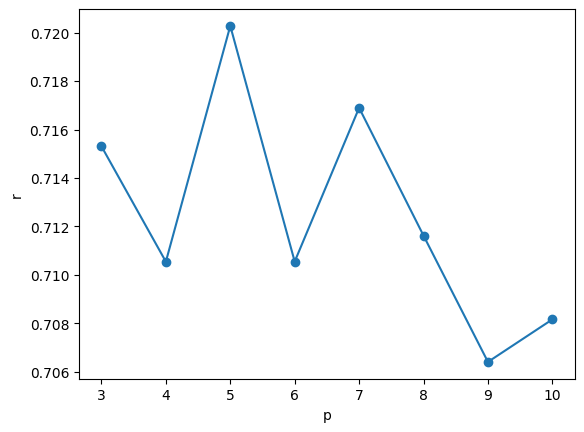

In [192]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
delta = results["Deltas"][0]
for i in range(results["sections"]):
    ax.plot(results["postprocessing"][delta].keys(), [results["postprocessing"][delta][p][i]["r"] for p in postprocessing[delta].keys()], marker="o")
ax.set_ylabel("r")

ax.set_xlabel("p")